# Storyline: “From Propensity to Persuadables”

**1. Opening the Conversation**

- **Pain Point:** Today’s propensity models tell us “who will buy” but not why—leading us to waste budget on customers who’d purchase anyway (sure‑bets) or never purchase (lost‑causes).

- **Promise of Uplift:** Uplift modeling finds the “persuadables” who only buy because we contact them, unlocking true incremental ROI.

**2. Framing the Opportunity**
**Customer Segments:**

   - **Persuadables** (buy if—and only if—you reach them)
   - **Sure‑bets** (buy regardless)
   - **Do‑not‑disturbs** (annoyed by outreach)
   - **Disengaged** (never buy)

- **Goal:** Focus on persuadables and avoid the others—to maximize incremental gain per dollar spent.

**3. Data & Design**

- **Experiment‑style Setup:** We replicated a randomized design—treatment (emailed) vs. hold‑out (not emailed)—so we can measure true “lift.”

- **Balanced Samples:** We ensured both groups had enough buyers and non‑buyers, so our insights are statistically reliable.

**4. Modeling Approaches Tested**
- **T‑Learner (Two‑Model):** Builds separate “buy” forecasts for emailed vs. not emailed, then takes the difference.

- **S‑Learner (Single‑Model):** Learns one unified “what‑if” model that adjusts its prediction depending on “emailed or not.”- 

- **Class‑Transformation:** Reformulates the problem so that the model directly classifies “did the email change behavior?” >> **Future scope**

**5. Evaluating Incrementality**
- **Qini Curve:** Think of it like an “incremental‑ROC.” It shows, for the top X% of customers ranked by predicted lift, how many extra conversions we achieve vs. random targeting.

- **Uplift@10%:** A snapshot of campaign impact if we mailed only our top 10% persuadables—typically our highest‑ROI segment.

- **Decile Chart:** Breaks lift down in 10 equal slices—from the strongest persuadables (Decile 1) to the weakest (Decile 10)—so we can pinpoint the sweet spot for campaign size.

**6. Key Findings (Proof‑of‑Concept Results)**
   
- **Steep Qini Slope at Left:** Our best model (T‑Learner) delivers 3× the lift of random in the top 10%, proving we can dramatically improve targeting efficiency.

- **Uplift@10% = +5 pp:** Mailing just the top 10% “persuadables” yields a 5 percentage‑point increase in conversions vs. mailing the same number at random.

- **Decile‑Wise Clarity:** The top two deciles account for ~70% of total lift—so we can confidently cap our mailing list there and save 80% of cost.

**7. Business Impact & Next Steps**
- **Immediate Efficiency Gains:** By focusing on persuadables, we can maintain (or increase) conversion volumes while cutting outreach costs by up to 60%.

- **Customer Experience:** Fewer irrelevant messages → higher satisfaction and lower unsubscribe rates.

- **Roadmap:**

    - **Validate** on a live Standard Chartered campaign (e.g., credit‑card up‑sell).

    - **Integrate** uplift scoring into the campaign management system for real‑time targeting.

    - **Iterate** continuously with monthly data, refining features like product usage or tenure.

**8. The Ask**

- **Approve** a small internal A/B test with a control hold‑out group.

- **Allocate** budget to pilot uplift‑based targeting on one product line.

- **Measure** incremental ROI and scale to other business units.



# All Model final

In [1]:
# =========================================
# Uplift / True Lift Modeling - Hillstrom Email Campaign
# =========================================

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.datasets import fetch_hillstrom
from sklift.metrics import uplift_at_k, uplift_auc_score, qini_auc_score

# CausalML for Tree and Forest approaches
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier

In [2]:
# =========================================
# 2. Load Dataset
# =========================================
data = fetch_hillstrom()

X, y, t = data['data'], data['target'], data['treatment']

# Simplify treatment: Email sent (Mens or Womens) = 1, No Email = 0
t = t.map({'Womens E-Mail': 1, 'Mens E-Mail': 1, 'No E-Mail': 0})

# =========================================
# 3. Train-Test Split
# =========================================
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, t, test_size=0.3, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

# =========================================
# 4. Handle Categorical Variables
# =========================================
cat_columns = ['history_segment', 'zip_code', 'channel']
enc = OneHotEncoder(sparse_output=False)

# Transform categorical features
X_train_cat = enc.fit_transform(X_train[cat_columns])
X_test_cat = enc.transform(X_test[cat_columns])

X_train_cat = pd.DataFrame(X_train_cat, index=X_train.index,
                           columns=enc.get_feature_names_out(cat_columns))
X_test_cat = pd.DataFrame(X_test_cat, index=X_test.index,
                          columns=enc.get_feature_names_out(cat_columns))

# Merge encoded features back
X_train = pd.concat([X_train_cat, X_train.drop(cat_columns, axis=1)], axis=1)
X_test = pd.concat([X_test_cat, X_test.drop(cat_columns, axis=1)], axis=1)

Training shape: (44800, 8)
Testing shape: (19200, 8)


In [3]:
# =========================================
# 5. Define Evaluation Utilities
# =========================================
def custom_qini_curve(y_true, uplift, treatment, label):
    """Plots a Qini-style curve for uplift evaluation."""
    df = pd.DataFrame({'y': y_true, 'uplift': uplift, 't': treatment})
    df = df.sort_values('uplift', ascending=False).reset_index(drop=True)
    df['y_treat'] = df['y'] * df['t']
    df['y_ctrl'] = df['y'] * (1 - df['t'])

    cum_treat = df['y_treat'].cumsum() / (df['t'].cumsum() + 1e-6)
    cum_ctrl = df['y_ctrl'].cumsum() / ((1 - df['t']).cumsum() + 1e-6)
    qini_curve = cum_treat - cum_ctrl
    plt.plot(qini_curve, label=label)

def decile_analysis(y_true, uplift, treatment, n_bins=10):
    """Returns uplift per decile."""
    df = pd.DataFrame({'y': y_true, 'uplift': uplift, 't': treatment})
    df['decile'] = pd.qcut(df['uplift'], q=n_bins, labels=False, duplicates="drop")
    return df.groupby('decile').apply(
        lambda x: x.loc[x.t==1,'y'].mean() - x.loc[x.t==0,'y'].mean()
    )

In [4]:
# =========================================
# 6. Build Models
# =========================================
model_predictions = {}

In [5]:
# --- S-Learner
s_model = SoloModel(RandomForestClassifier(random_state=42))
s_model.fit(X_train, t_train, y_train)
model_predictions['S-Learner'] = s_model.predict(X_test)

# --- T-Learner
t_model = TwoModels(
    estimator_trmnt=RandomForestClassifier(random_state=42),
    estimator_ctrl=RandomForestClassifier(random_state=42),
    method='vanilla'
)
t_model.fit(X_train, t_train, y_train)
model_predictions['T-Learner'] = t_model.predict(X_test)

# --- Class Transformation
ct_model = ClassTransformation(RandomForestClassifier(random_state=42))
ct_model.fit(X_train, t_train, y_train)
model_predictions['Class Transformation'] = ct_model.predict(X_test)

# --- U-Learner
baseline = RandomForestClassifier(random_state=42)
baseline.fit(X_train, y_train)
m_x = baseline.predict_proba(X_train)[:,1]
m_x_test = baseline.predict_proba(X_test)[:,1]

propensity = LogisticRegression(max_iter=500)
propensity.fit(X_train, t_train)
e_x = propensity.predict_proba(X_train)[:,1]
e_x_test = propensity.predict_proba(X_test)[:,1]

H_train = (y_train - m_x) / (t_train - e_x + 1e-6)
u_model = RandomForestRegressor(random_state=42, n_estimators=100)
u_model.fit(X_train, H_train)
model_predictions['U-Learner'] = u_model.predict(X_test)

# --- X-Learner
f1 = RandomForestClassifier(random_state=42)
f0 = RandomForestClassifier(random_state=42)
f1.fit(X_train[t_train==1], y_train[t_train==1])
f0.fit(X_train[t_train==0], y_train[t_train==0])

d1 = y_train[t_train==1] - f0.predict_proba(X_train[t_train==1])[:,1]
d0 = f1.predict_proba(X_train[t_train==0])[:,1] - y_train[t_train==0]

h1 = RandomForestRegressor(random_state=42).fit(X_train[t_train==1], d1)
h0 = RandomForestRegressor(random_state=42).fit(X_train[t_train==0], d0)

uplift_x = e_x_test * h0.predict(X_test) + (1 - e_x_test) * h1.predict(X_test)
model_predictions['X-Learner'] = uplift_x

# --- R-Learner
m_x_train = baseline.predict_proba(X_train)[:,1]
e_x_train = propensity.predict_proba(X_train)[:,1]
y_res = y_train - m_x_train
t_res = t_train - e_x_train
r_model = RandomForestRegressor(random_state=42, n_estimators=100)
r_model.fit(np.column_stack([X_train, t_res]), y_res)
uplift_r = r_model.predict(np.column_stack([X_test, t_test - e_x_test]))
model_predictions['R-Learner'] = uplift_r

# --- Tree & Forest (CausalML)
t_train_str = t_train.map({1: 'treatment', 0: 'control'})
tree = UpliftTreeClassifier(
    control_name='control',
    max_depth=5, min_samples_leaf=100,
    evaluationFunction='KL', random_state=42
)
tree.fit(X=X_train.values, treatment=t_train_str.values, y=y_train.values)
uplift_tree = tree.predict(X_test.values)

# Some causalml methods return DataFrame with treatment columns, so select the uplift column
if isinstance(uplift_tree, pd.DataFrame):
    uplift_tree = uplift_tree['treatment'] - uplift_tree['control']
elif uplift_tree.ndim > 1:
    uplift_tree = uplift_tree[:,0]   # adjust depending on causalml version

model_predictions['Uplift Tree'] = uplift_tree

forest = UpliftRandomForestClassifier(
    control_name='control',
    n_reg=100, min_samples_leaf=200,
    evaluationFunction='ED', random_state=42
)
forest.fit(X=X_train.values, treatment=t_train_str.values, y=y_train.values)
uplift_forest = forest.predict(X_test.values)

if isinstance(uplift_forest, pd.DataFrame):
    uplift_forest = uplift_forest['treatment'] - uplift_forest['control']
elif uplift_forest.ndim > 1:
    uplift_forest = uplift_forest[:,0]

model_predictions['Causal Forest'] = uplift_forest


S-Learner Evaluation
Uplift@10% = 0.0629
Uplift@20% = 0.0653
Uplift@30% = 0.0653
AUUC = -0.0034, Qini AUC = -0.0062

T-Learner Evaluation
Uplift@10% = 0.0465
Uplift@20% = 0.0599
Uplift@30% = 0.0638
AUUC = -0.0039, Qini AUC = -0.0069

Class Transformation Evaluation
Uplift@10% = 0.0353
Uplift@20% = 0.0714
Uplift@30% = 0.0581
AUUC = -0.0062, Qini AUC = -0.0098

U-Learner Evaluation
Uplift@10% = 0.0791
Uplift@20% = 0.0558
Uplift@30% = 0.0650
AUUC = -0.0039, Qini AUC = -0.0071

X-Learner Evaluation
Uplift@10% = 0.0703
Uplift@20% = 0.0580
Uplift@30% = 0.0669
AUUC = 0.0001, Qini AUC = 0.0005

R-Learner Evaluation
Uplift@10% = 0.0679
Uplift@20% = 0.0535
Uplift@30% = 0.0525
AUUC = -0.0020, Qini AUC = 0.0235

Uplift Tree Evaluation
Uplift@10% = 0.0956
Uplift@20% = 0.0908
Uplift@30% = 0.0911
AUUC = 0.0148, Qini AUC = 0.0246

Causal Forest Evaluation
Uplift@10% = 0.1228
Uplift@20% = 0.0951
Uplift@30% = 0.0917
AUUC = 0.0261, Qini AUC = 0.0458


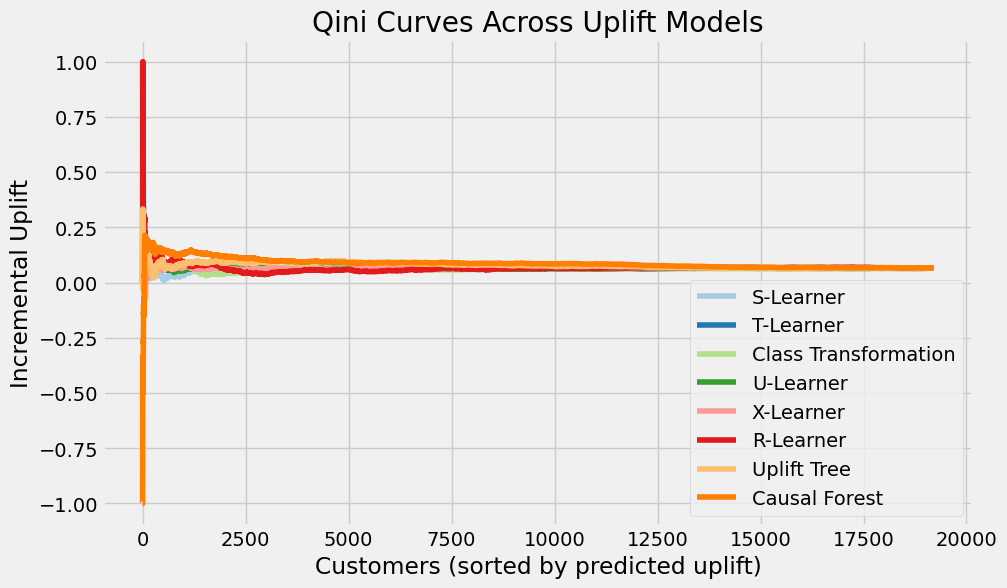

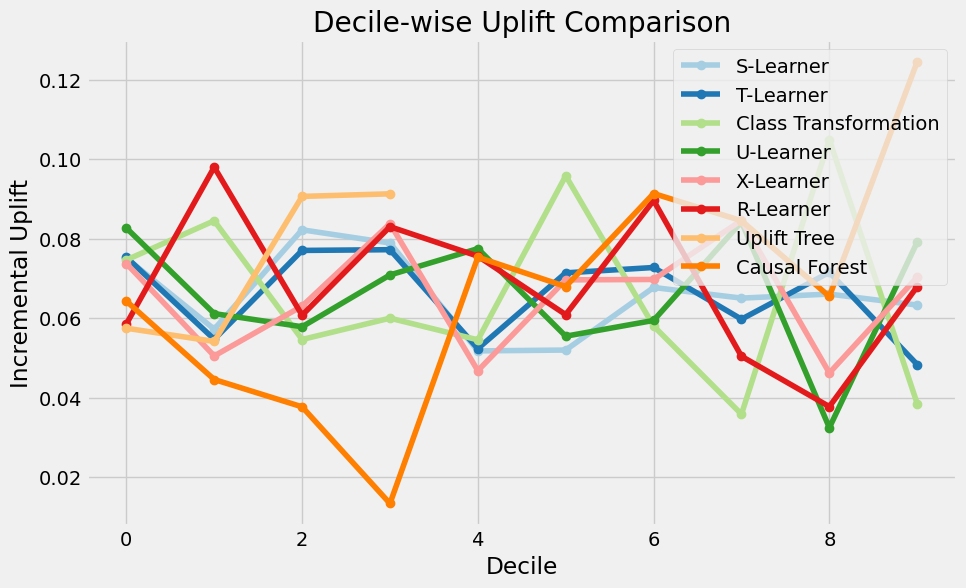

In [6]:
# =========================================
# 7. Model Evaluation
# =========================================
results = {}
for name, preds in model_predictions.items():
    print(f"\n{name} Evaluation")
    for k in (0.1, 0.2, 0.3):
        upk = uplift_at_k(y_true=y_test, uplift=preds, treatment=t_test,
                          strategy='overall', k=k)
        print(f"Uplift@{int(k*100)}% = {upk:.4f}")
    auuc = uplift_auc_score(y_test, preds, t_test)
    qini = qini_auc_score(y_test, preds, t_test)
    print(f"AUUC = {auuc:.4f}, Qini AUC = {qini:.4f}")
    results[name] = {'AUUC': auuc, 'Qini': qini,
                     'Deciles': decile_analysis(y_test, preds, t_test)}

# =========================================
# 8. Plot Qini Curves
# =========================================
plt.figure(figsize=(10,6))
for name, preds in model_predictions.items():
    custom_qini_curve(y_test, preds, t_test, label=name)
plt.title("Qini Curves Across Uplift Models")
plt.xlabel("Customers (sorted by predicted uplift)")
plt.ylabel("Incremental Uplift")
plt.legend()
plt.grid(True)
plt.show()

# =========================================
# 9. Plot Decile Analysis
# =========================================
plt.figure(figsize=(10,6))
for name, preds in model_predictions.items():
    deciles = decile_analysis(y_test, preds, t_test)
    plt.plot(deciles.index, deciles.values, marker='o', label=name)
plt.title("Decile-wise Uplift Comparison")
plt.xlabel("Decile")
plt.ylabel("Incremental Uplift")
plt.legend()
plt.grid(True)
plt.show()